# Variational Monte Carlo Using St|eepest Descent

In [1]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output
from math import exp

from pdb import set_trace

## Monte Carlo Functions

In [2]:
# 1 is up and 0 is down
# these are all the possible ground configurations that might
# contribute to the ground states

# this version makes it readable
states = np.asarray([
    [1, 1, 0, 0],
    [0, 0, 1, 1],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 0, 1],
    [0, 1, 1, 0],
])

# this line turns all the 0s to -1s for computational purposes
states = states*2 - 1; states

array([[ 1,  1, -1, -1],
       [-1, -1,  1,  1],
       [ 1, -1,  1, -1],
       [-1,  1, -1,  1],
       [ 1, -1, -1,  1],
       [-1,  1,  1, -1]])

In [3]:
def get_random_state():
    return random.choice(states)

In [4]:
def get_variational_projection(state, alpha):
    """
    This function computes the projection of state in the spin basis
    onto the varitional wave function
    """
    exponent = 0 
    # FOO DO WE COUNT THE SUMS TWICE?
    for i in range(len(state)):
        for j in range(0, len(state)):
            if i is not j:
                new_exp_term = (alpha/(min(abs(i-j),abs((i-len(state)) - j), abs(i - (j-len(state))))))*state[i]*state[j]/4 # need the "/4" because spin 1/2 particles
                exponent += new_exp_term
    return math.exp(exponent)

In [5]:
def get_off_diagonal_configurations(state):
    """
    This function generates a list of configurations that could
    be flipped into the inputted by state by the application of
    Raising or lowering operators (Check the hamiltonian equation)
    
    returns a list of configurations
    
    ***NOTE: This solution is computational intractable and might not
    be the most optimal one
    """
    state_copy = state.copy()
    off_diagonal_configurations = list()
    for i in range(len(state)):
        if i == len(state) - 1:
            if state[i] != state[0]:
                state_copy[i] *= -1
                state_copy[0] *= -1
                off_diagonal_configurations.append(state_copy)
            return off_diagonal_configurations
        if state[i] != state[i+1]:
            state_copy[i] *= -1
            state_copy[i+1] *= -1
            off_diagonal_configurations.append(state_copy)
            state_copy = state.copy()

In [9]:
def calculate_local_energy(state, alpha):
    """
    This function calculates the local energy of a state
    """
    # contribution from Z direction spin terms
    energy = 0
    state_proj = get_variational_projection(state, alpha)
    for i in range(len(state)):
        if i == len(state) - 1:
            energy += (state_proj*state[i] * state[0])/4
        else:
            energy += (state_proj*state[i] * state[i+1])/4
            
    # contributions from off diagonal terms
    non_diagonal_energies = 0
    off_diag_config_states = get_off_diagonal_configurations(state)
    for configuration in off_diag_config_states:
        non_diagonal_energies += (-0.5)*get_variational_projection(configuration, alpha)
    energy += non_diagonal_energies
    return energy / state_proj

In [10]:
def compute_R(trial_state, initial_state, alpha):
    """
    Function compute "R", which is the ratio between the weight functions
    of the initial state and the trial state.
    """
    numerator = get_variational_projection(trial_state, alpha) **2
    denominator = get_variational_projection(initial_state, alpha) **2
    return numerator / denominator

In [11]:
def random_flip(state):
    """
    Randomly flips two bits of a state such
    that there are still two up and two down
    """
    choices = random.sample(list(range(0,len(state))), len(state))
    flip1_index = choices.pop()
    flip1_value = state[flip1_index]
    state[flip1_index] *= -1
    cont = True
    while(cont):
        flip2_index = choices.pop()
        if state[flip2_index] != flip1_value:
            state[flip2_index] *= -1
            cont = False
    return state

In [12]:
def monte_carlo_estimation(alpha, num_steps):
    x_initial = get_random_state()
    running_total = 0
    for i in range(num_steps):
        x_trial = random_flip(x_initial.copy())
        R = compute_R(x_trial, x_initial, alpha)
        r = random.uniform(0,1)
        if R > r:
            x_initial = x_trial.copy()
        running_total += calculate_local_energy(x_initial, alpha)
    return running_total / num_steps

## Scan The Solution Space to find the Optimal Alpha and the Minimum Energy


In [15]:
# This function was derived analytically, and represents
# what we should expect out of the energy curve

def ground_truth_variational_energy(alpha):
    """
    with respect to alpha
    """
    numerator = -4*exp(-2*alpha) + -1*exp(-3*alpha)
    denominator = 2*exp(-1*alpha) + exp(-3*alpha)
    
    return numerator/denominator

In [16]:
def get_optimal_alpha(alphas, num_steps=5000):
    energies = list()
    for i, alpha in enumerate(alphas):
        clear_output(wait=True)
        print(f"Alpha: {i+1}/{len(alphas)}")
        energies.append(monte_carlo_estimation(alpha, num_steps))
    return alphas[np.argmin(energies)], np.argmin(energies), energies

Alpha: 20/20


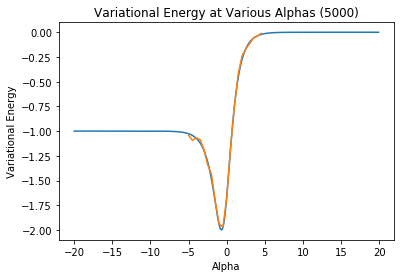

Optimal Alpha found at -0.5
Minimum Energy: -1.9706208344928617


In [17]:
## alphas = [i*0.05 for i in range(20,40)]
num_steps = 5000
alphas = [i*0.5 for i in range(-10,10)]
xs = np.asarray([i*0.1 for i in range(-200, 200)])
ys = np.asarray([ground_truth_variational_energy(x) for x in xs])

optimal_alpha, index, energies = get_optimal_alpha(alphas, num_steps=num_steps)

plt.plot(xs, ys)
plt.plot(alphas, energies)
# plt.xlim(1,2)
plt.ylim()
plt.ylabel("Variational Energy")
plt.xlabel("Alpha")
plt.title(f"Variational Energy at Various Alphas ({num_steps})")
plt.show()
print(f"Optimal Alpha found at {optimal_alpha}")
print(f"Minimum Energy: {energies[index]}")

## Sorella's Derivative Estimation Function

In [18]:
def get_variational_energy_derivative(E_var, alpha):
    """
    This function gets the derivative of the variational energy with
    respect to alpha. Currently, it just uses the expression I derived
    analytically, but it will need to be rewritten for the sake of 
    generalizability
    Args:
    - E_var (float) : Variational Energy
    - alpha (float) : alpha
    return:
    - derivative of E_var with respect to alpa (float)
    """
    a = 8*exp(-2*alpha) + 3*exp(-3*alpha)
    b = -2*exp(-1*alpha) - 3*exp(-3*alpha)
    denom = 4*exp(-1*alpha) + 2*exp(-3*alpha)
    return 2*(a - E_var*b)/denom

In [31]:
def find_optimal_alpha(lr = 0.03, num_steps =1000):
    """
    Note: only finds local minimums
    
    Algorithm will continue an additional 10 iterations
    after finding what it thinks is the optimal value
    """
    
    # cap the change in alpha
    d_alpha_cap = 0.3
    
    # get inital condition
    alphas = [] # list of all alphas that we test
    energies = [] # list of all energies corresponding to those alphas
    alpha = random.randint(-1000,1000)/100 # initial guess at alpha
    
    # pre loop conditions
    cont = True
    min_energy = 99999999999
    i = 0
    loop_count = 0
    plt.axis([0, 10, 0, 1])
    while(cont):
        clear_output(wait=True)
        # print(f"Loop Number: {loop_count} \nEnd Count: {i} \nAlpha: {alpha} \nMin Energy: {min_energy}")
        energy = monte_carlo_estimation(alpha, num_steps)
        derivative = get_variational_energy_derivative(energy, alpha)
        plt.plot(alphas, energies)
        plt.show()
        # update logs
        alphas.append(alpha)
        energies.append(energy)
        
        # if this energy is lowest, update optimal measurements,
        # and assume you can do better (set end count, i, to zero)
        if energy < min_energy:
                min_energy = energy
                opt_alpha = alpha
                i = 0
        # if not, inncrement the end count. If you don't get better
        # after 100 tries, it's probably time to stop
        else:
            i += 1
            if i == 400:
                cont = False
        # in case our derivative is close to zero
        if abs(lr*energy/derivative) > d_alpha_cap:
            derivative = lr*energy/d_alpha_cap
        
        try:
            alpha = alpha + lr*energy/derivative
        except ZeroDivisionError:
            alpha = alpha + lr*energy/(derivative+2)
            
        loop_count += 1
            
    print("Optimal Alpha: %3.2f" % opt_alpha)
    print("Optimal Energy: %3.2f" % min_energy)

    return opt_alpha, min_energy, alphas, energies

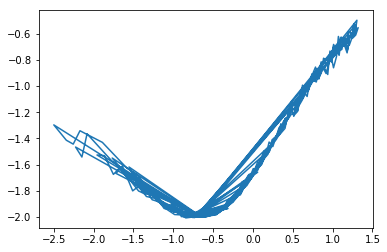

Optimal Alpha: -0.84
Optimal Energy: -2.01


In [33]:
opt_alpha, min_energy, alphas, energies = find_optimal_alpha()